In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input

# Load data

In [12]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df = df.resample('1h').mean().ffill()  # Resample to hourly data
df["value"] = df["value"].astype(float)

# Normalize Data
scaler = MinMaxScaler()
df["value_scaled"] = scaler.fit_transform(df["value"].values.reshape(-1, 1))


# Exploring the data


Time series decomposition over each day

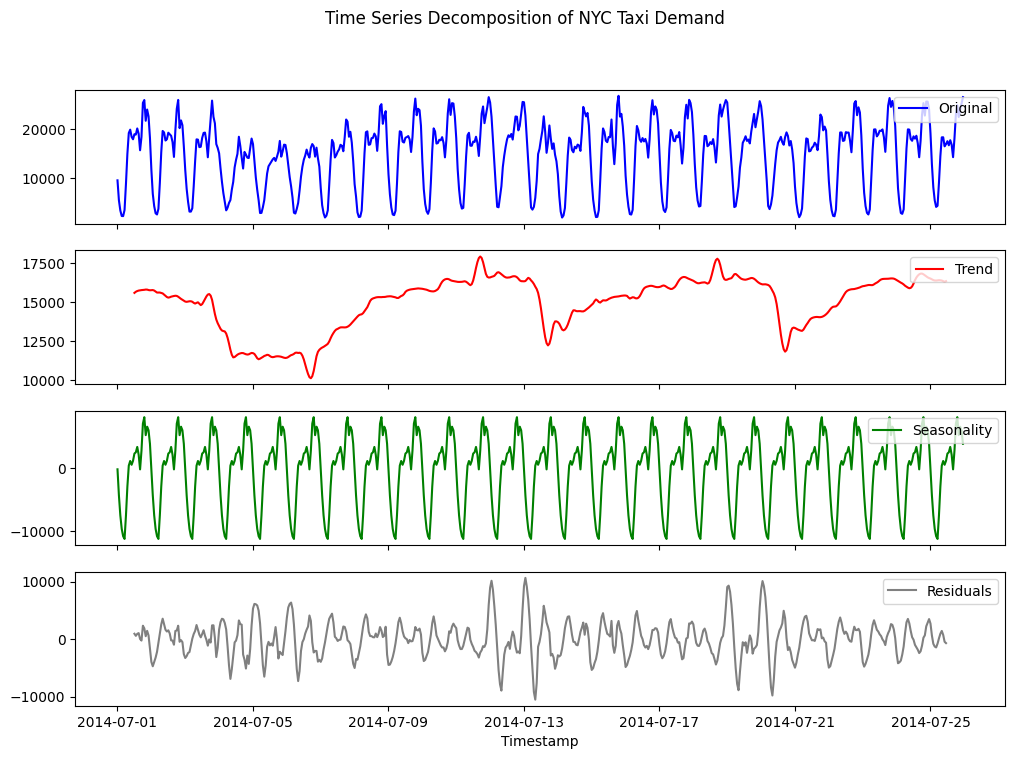

In [13]:
# Decomposition for a short duration of time
result = seasonal_decompose(df["value"][:600], model="additive", period=24)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df["value"][:600], label="Original", color="blue")
axes[0].legend(loc="upper right")

axes[1].plot(result.trend, label="Trend", color="red")
axes[1].legend(loc="upper right")

axes[2].plot(result.seasonal, label="Seasonality", color="green")
axes[2].legend(loc="upper right")

axes[3].plot(result.resid, label="Residuals", color="gray")
axes[3].legend(loc="upper right")

plt.xlabel("Timestamp")
plt.suptitle("Time Series Decomposition of NYC Taxi Demand")
plt.show()

We observe that there are weekly patterns over the observed time period.   
  
Now decomposing over a time period of 1 week.

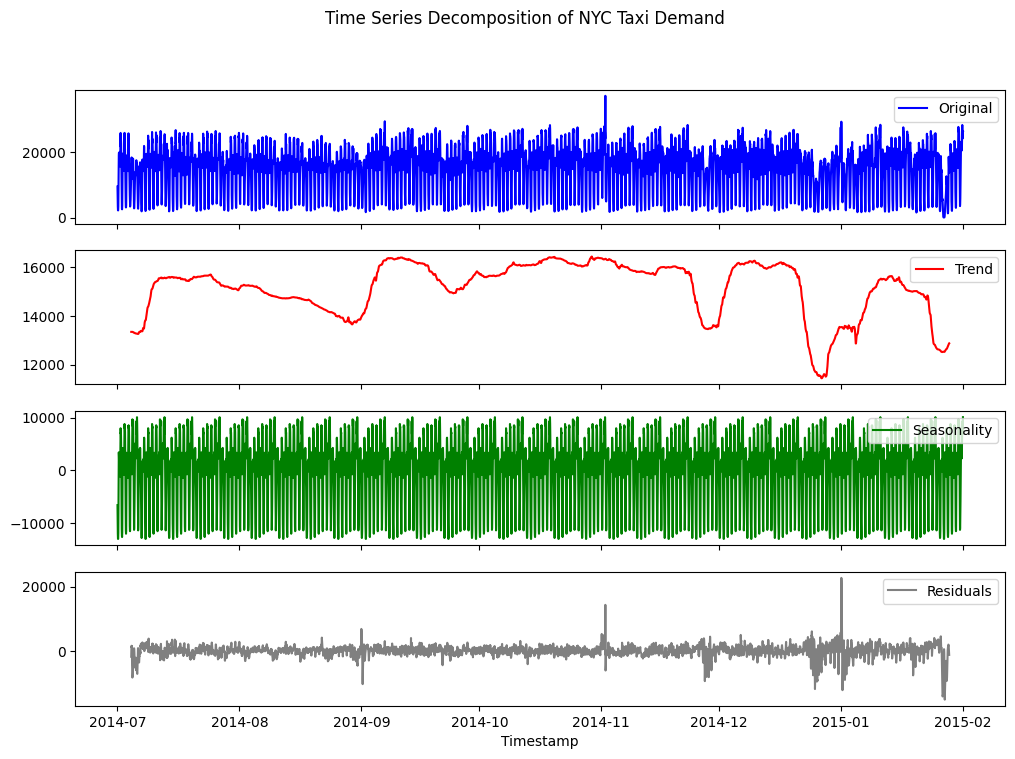

In [14]:
result = seasonal_decompose(df["value"], model="additive", period=24*7)
df["smoothed_value"] = result.trend

# Drop NaN values that arise due to decomposition
# df.dropna(subset=["smoothed_value"], inplace=True)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df["value"], label="Original", color="blue")
axes[0].legend(loc="upper right")

axes[1].plot(result.trend, label="Trend", color="red")
axes[1].legend(loc="upper right")

axes[2].plot(result.seasonal, label="Seasonality", color="green")
axes[2].legend(loc="upper right")

axes[3].plot(result.resid, label="Residuals", color="gray")
axes[3].legend(loc="upper right")

plt.xlabel("Timestamp")
plt.suptitle("Time Series Decomposition of NYC Taxi Demand")
plt.show()

# Prepare Sequences for LSTM


In [15]:
def create_sequences(data, time_steps=48):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 48  # 2 days of hourly data
X, y = create_sequences(df["value_scaled"].values, time_steps)


# Build LSTM Autoencoder



In [16]:
# Define model with explicit Input layer
model = Sequential([
    Input(shape=(time_steps, 1)),  # Explicit input layer
    LSTM(100, activation="relu", return_sequences=True),
    LSTM(50, activation="relu", return_sequences=False),
    RepeatVector(time_steps),
    LSTM(50, activation="relu", return_sequences=True),
    LSTM(100, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

# Compile and train the model
model.compile(optimizer="adam", loss="mse")
model.fit(X, X, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.0782 - val_loss: 0.0371
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0327 - val_loss: 0.0325
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0291 - val_loss: 0.0225
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0152 - val_loss: 0.0107
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0039 - val_loss: 0.0066
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0035 - val_loss: 0.0059
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 12/20
144/144 ━━━━━━━━━━━━━━━━━━━

# Predict anomalies

In [17]:
# Compute Reconstruction Errors
X_pred = model.predict(X)
reconstruction_errors = np.mean(np.abs(X_pred - X.reshape(*X.shape, 1)), axis=(1,2))

# Set Threshold for Anomaly Detection
threshold = np.percentile(reconstruction_errors, 97)
anomalies = reconstruction_errors > threshold

df["anomaly_score"] = np.concatenate([np.zeros(time_steps), reconstruction_errors])
df["anomaly"] = np.concatenate([np.zeros(time_steps), anomalies.astype(int)])


160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


# Visualize Results


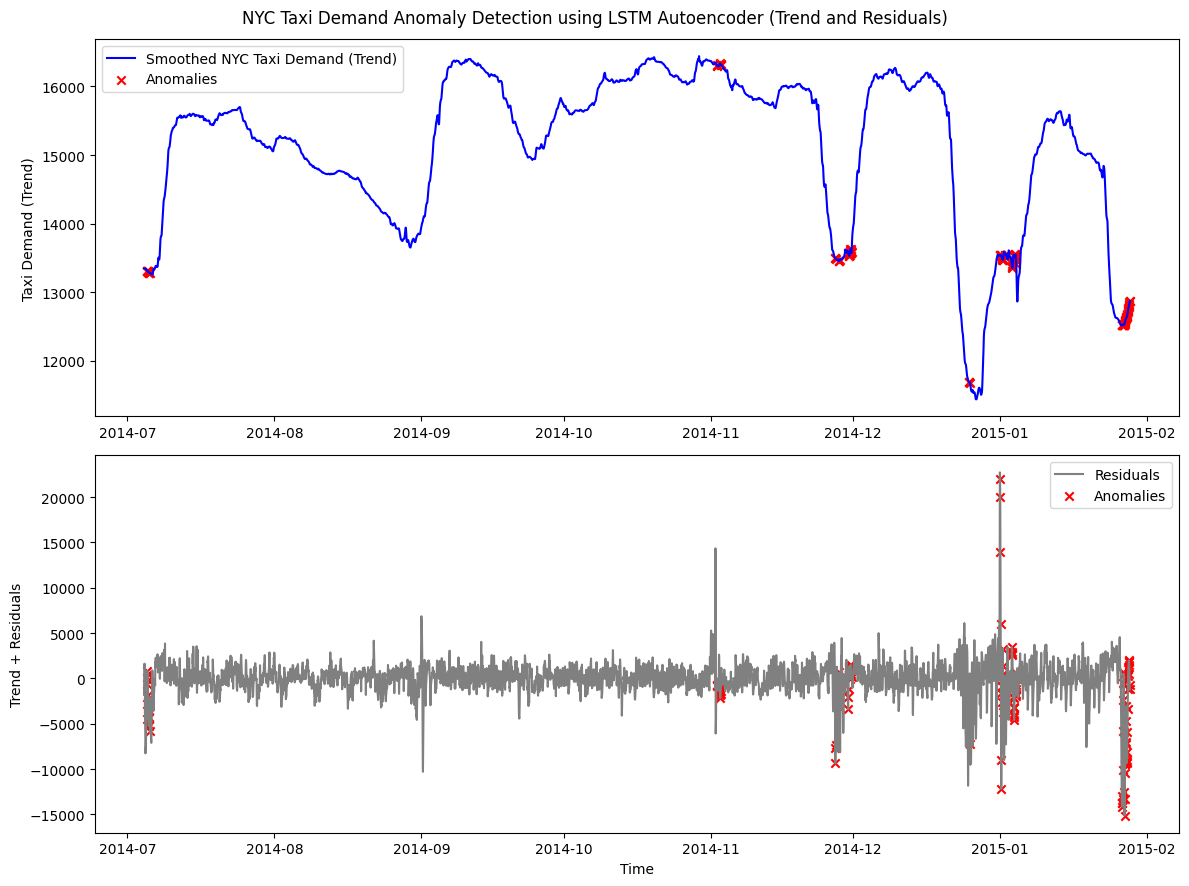

In [18]:
# Visualize anomalies using the trend and residual components

plt.figure(figsize=(12, 9))

# Plot the smoothed trend
plt.subplot(2, 1, 1)
plt.plot(df.index, df["smoothed_value"], label="Smoothed NYC Taxi Demand (Trend)", color="blue")
plt.scatter(df.index[df["anomaly"] == 1], df["smoothed_value"][df["anomaly"] == 1],
            color="red", label="Anomalies", marker="x")
plt.ylabel("Taxi Demand (Trend)")
plt.legend()

# Plot the residuals
plt.subplot(2, 1, 2)
plt.plot(df.index, result.resid, label="Residuals", color="gray")
plt.scatter(df.index[df["anomaly"] == 1], result.resid[df["anomaly"] == 1],
            color="red", label="Anomalies", marker="x")
plt.ylabel("Residuals")
plt.legend()

plt.xlabel("Time")
plt.ylabel("Trend + Residuals")
plt.legend()

plt.suptitle("NYC Taxi Demand Anomaly Detection using LSTM Autoencoder (Trend and Residuals)")
plt.tight_layout()
plt.show()
